In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns

tfd = tfp.distributions

sns.set(style="white")

In [2]:
print("The GPflow version is {0}".format(gpflow.__version__))
print("The tensorflow version is {0}".format(tf.__version__))
print("The tensorflow-probability version is {0}".format(tfp.__version__))

The GPflow version is 2.0.5
The tensorflow version is 2.2.0
The tensorflow-probability version is 0.10.0


# Load datasets

Load the Google Mobility report [link](https://www.google.com/covid19/mobility/https://www.google.com/covid19/mobility/) and the COVID data from the UK government webiste [link](https://coronavirus.data.gov.uk). 

In [3]:
covid_cases = pd.read_csv("./Data/Daily COVID Cases/ONS_Daily_COVID_JULY.csv")
covid_cases["Date"] = pd.to_datetime(covid_cases["Date"], format='%d/%m/%Y')
mobility_data = pd.read_csv("./Data/Google/Global_Mobility_Report.csv", encoding = "ISO-8859-1")
mobility_data["date"] = pd.to_datetime(mobility_data["date"], format='%d/%m/%Y')

/Users/georgiospapadopoulos/opt/anaconda3/envs/argos/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
covid_cases.dtypes

Date                   datetime64[ns]
Previously reported             int64
Change                          int64
Confirmed cases                 int64
dtype: object

In [5]:
covid_cases.shape

(168, 4)

In [6]:
mobility_data.dtypes

country_region_code                                           object
country_region                                                object
sub_region_1                                                  object
sub_region_2                                                  object
metro_area                                                    object
iso_3166_2_code                                               object
census_fips_code                                             float64
date                                                  datetime64[ns]
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

In [7]:
mobility_data.shape

(1048575, 14)

# Explore the Google Mobility Dataset

From the Google Mobility data we keep only the general UK cases. We do not go down to LAD (lower administrative level).

In [8]:
mobility_data = mobility_data[(mobility_data.country_region=="United Kingdom") & (mobility_data.sub_region_1.isnull())]

In [11]:
mobility_data = mobility_data.iloc[:,7:].reset_index(drop=True) # keep only relevant columns

In [12]:
mobility_data.columns

Index(['date', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

We preprocess the data to show the change in mobility as a factor, $<1$ if there is a decrease in mobility compared to the fixed baseline (prior to 15/02/2020) and $>1$ if there is an increase in mobility compared to the fixed baseline.

In [13]:
# transform the data to pct change
mobility_data[mobility_data.columns[1:]] = mobility_data[mobility_data.columns[1:]].apply(lambda x: x/100 + 1)

In [14]:
data = pd.DataFrame(mobility_data["date"])

Merge the Google mobility data to HOME, WORK, and OTHER, with OTHER include parks, transit, retail and grocery. 

In [15]:
data["HOME"] = mobility_data['residential_percent_change_from_baseline'].copy()
data["WORK"] = mobility_data['workplaces_percent_change_from_baseline'].copy()
data["OTHER"] = mobility_data.iloc[:,1:5].mean(axis=1)

Visually explore the dataset

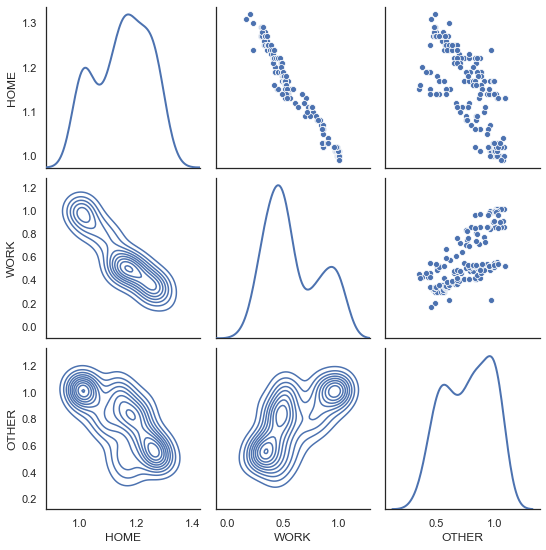

In [17]:
g = sns.PairGrid(data, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)

**Observations:** HOME and WORK have a strong negative correlation -.98 (as well as HOME and OTHER -.75), whereas HOME and OTHER have a positive correlation .75.

In [18]:
data.corr()

,HOME,WORK,OTHER
HOME,1.000000,-0.975783,-0.738397
WORK,-0.975783,1.000000,0.710473
OTHER,-0.738397,0.710473,1.000000


In [19]:
data["WEEKDAY"] = 0
data.loc[data.date.dt.dayofweek < 5, "WEEKDAY"] = 1
data["WEEKDAY"] = data["WEEKDAY"].astype("category")

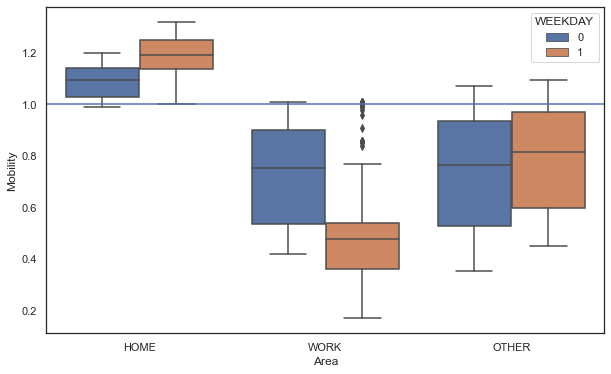

In [20]:
data_melt = pd.melt(data.iloc[:,1:4], var_name='Area', value_name='Mobility')
seq = cycle(data["WEEKDAY"])
data_melt['WEEKDAY'] = [next(seq) for count in range(data_melt.shape[0])]

plt.figure(figsize=(10,6))
sns.boxplot(x="Area", y="Mobility", hue="WEEKDAY", data=data_melt)
plt.axhline(y=1.0)

**Observations:** During lockdown period (15/02/2020 - 14/07/2020), the Google mobility data show increased mobility at HOME for weekdays. At WORK, is the opposite effect, during weekdays data show that mobility is only 50% of the baseline compared to weekends that is 80% of the baseline. In OTHER activities/areas the reduction between weekdays and weekend is approximately te same. 

# Explore the UK GOV COVID Dataset

In [21]:
covid_cases.drop(["Change", "Previously reported"], axis=1, inplace=True)

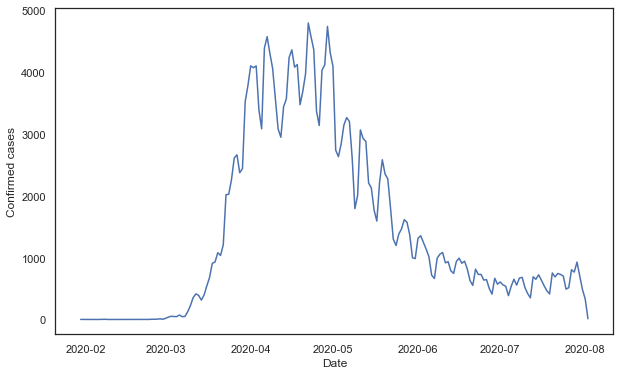

In [22]:
plt.figure(figsize=(10,6))
sns.lineplot(x="Date", y="Confirmed cases", data=covid_cases)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa392016ac8>]],
      dtype=object)

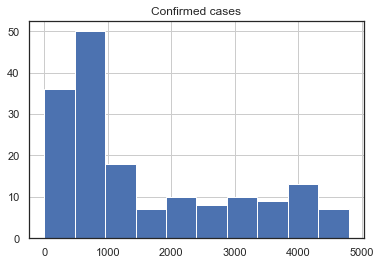

In [109]:
covid_cases.hist()

In [23]:
plot_data = covid_cases.copy()
plot_data["WEEKDAY"] = 0
plot_data.loc[plot_data.Date.dt.dayofweek < 5, "WEEKDAY"] = 1
plot_data["WEEKDAY"] = plot_data["WEEKDAY"].astype("category")

plot_data["MONTH"] = plot_data.Date.dt.month

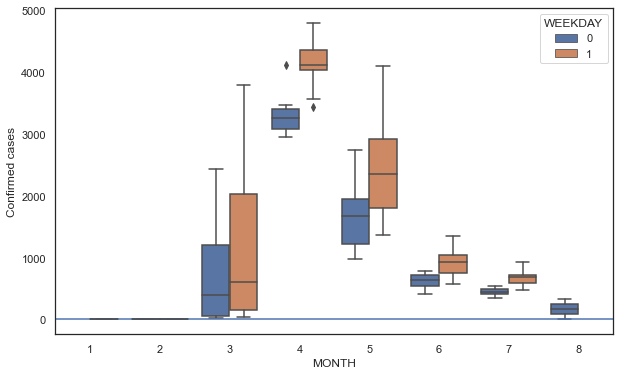

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x="MONTH", y="Confirmed cases", hue="WEEKDAY", data=plot_data)
plt.axhline(y=1.0)

In [25]:
data["MONTH"] = data.date.dt.month
data.groupby("MONTH").mean().T

MONTH,2,3,4,5,6,7
HOME,1.012667,1.092581,1.246000,1.205161,1.166333,1.118519
WORK,0.945333,0.770000,0.350333,0.449355,0.565333,0.629630
OTHER,0.987833,0.845081,0.510417,0.689113,0.791167,0.932222


# Merge the Datasets

In [26]:
final_data = covid_cases.merge(data.iloc[:,:-1], how='left', left_on='Date', right_on='date') 

In [27]:
final_data.dropna(axis=0, inplace=True)

In [28]:
final_data["Date_number"] = final_data.Date.dt.dayofyear - 50

In [29]:
final_data = final_data.drop(["date"], axis=1).reset_index(drop=True)

In [30]:
final_data

,Date,Confirmed cases,HOME,WORK,OTHER,WEEKDAY,Date_number
0,2020-02-21,1,1.03,0.85,1.0275,1,2
1,2020-02-24,2,1.01,0.98,0.9625,1,5
2,2020-02-25,5,1.00,1.01,1.0175,1,6
3,2020-02-26,4,1.00,1.01,1.0150,1,7
4,2020-02-27,7,1.00,1.00,1.0275,1,8
...,...,...,...,...,...,...,...
151,2020-07-23,729,1.14,0.53,0.9925,1,155
152,2020-07-24,703,1.13,0.54,1.0275,1,156
153,2020-07-25,492,1.06,0.85,0.8300,0,157
154,2020-07-26,515,1.03,0.91,0.9950,0,158


# Include Mixing Matrix Information

In [40]:
test2 = final_data.copy()
test2["Confirmed cases"] = test2["Confirmed cases"].astype("float")

We will use the largest eigenvalue from each mixing matrix type (workplace, other, home) in order to adjust the mobility data. 

The reasoning is that the mixing matrix represents static information about the social mixing habits in the UK during a benchmark/normal period (2017-2018). We wish to incorporate into this the latest developments after lockdown and make the mixing matrix time-dependent. 

In [41]:
C_HOME = pd.read_csv("./Data/BBC/HOME.csv", index_col=0)
u, s, vh = np.linalg.svd(C_HOME.fillna(0), full_matrices=True)
test2["HOME"] = test2["HOME"]*s[0] #largest eigenvalue

C_WORK = pd.read_csv("./Data/BBC/WORK.csv", index_col=0)
u, s, vh = np.linalg.svd(C_WORK.fillna(0), full_matrices=True)
test2["WORK"] = test2["WORK"]*s[0] #largest eigenvalue

C_OTHER = pd.read_csv("./Data/BBC/OTHER.csv", index_col=0)
u, s, vh = np.linalg.svd(C_OTHER.fillna(0), full_matrices=True)
test2["OTHER"] = test2["OTHER"]*s[0] #largest eigenvalue

test2["WEEKDAY"] = test2["WEEKDAY"].astype("float")
test2["Date_number"] = test2["Date_number"].astype("float")
test2

,Date,Confirmed cases,HOME,WORK,OTHER,WEEKDAY,Date_number
0,2020-02-21,1.0,1.480030,0.387905,0.816178,1.0,2.0
1,2020-02-24,2.0,1.451291,0.447232,0.764547,1.0,5.0
2,2020-02-25,5.0,1.436922,0.460922,0.808235,1.0,6.0
3,2020-02-26,4.0,1.436922,0.460922,0.806249,1.0,7.0
4,2020-02-27,7.0,1.436922,0.456359,0.816178,1.0,8.0
...,...,...,...,...,...,...,...
151,2020-07-23,729.0,1.638091,0.241870,0.788377,1.0,155.0
152,2020-07-24,703.0,1.623722,0.246434,0.816178,1.0,156.0
153,2020-07-25,492.0,1.523137,0.387905,0.659297,0.0,157.0
154,2020-07-26,515.0,1.480030,0.415287,0.790362,0.0,158.0


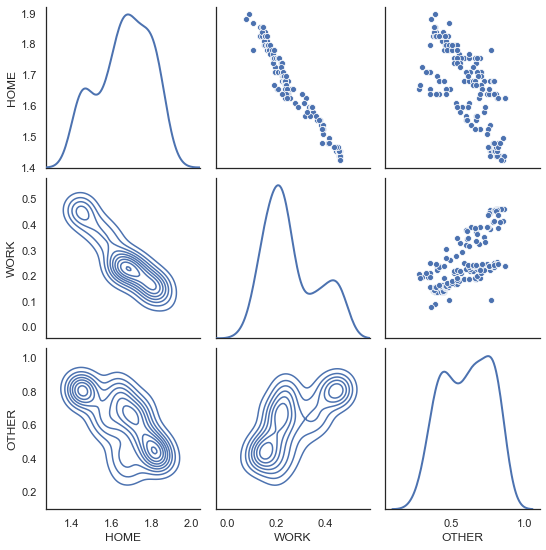

In [67]:
g = sns.PairGrid(test2[["HOME", "WORK", "OTHER"]], diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot, colors="C0")
g.map_diag(sns.kdeplot, lw=2)

In [68]:
test2[["HOME", "WORK", "OTHER"]].corr()

,HOME,WORK,OTHER
HOME,1.000000,-0.973893,-0.724510
WORK,-0.973893,1.000000,0.697917
OTHER,-0.724510,0.697917,1.000000


In [42]:
y = test2["Confirmed cases"].to_numpy()
X = test2[["HOME", "WORK", "OTHER", "Date_number", "WEEKDAY"]].to_numpy()
#X = test2["Date_number"].to_numpy()

In [43]:
X.shape[0]

156

In [44]:
split = 144

y_train = y[:split]
y_test = y[split:]

X_train = X[:split]
X_test = X[split:]

In [45]:
y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))

# Comment out if n.vars>1
#X_train = X_train.reshape((-1,1))
#X_test = X_test.reshape((-1,1))

In [46]:
k = gpflow.kernels.Matern52()

SE = gpflow.kernels.SquaredExponential()
LIN = gpflow.kernels.Linear()
RQ = gpflow.kernels.RationalQuadratic()
k = SE*LIN*RQ

print_summary(k)

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Product.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Product.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─

In [47]:
m = gpflow.models.VGP(data=(X_train, y_train), likelihood=gpflow.likelihoods.Gaussian(), kernel=k, mean_function=None)
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value            │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════╡
│ VGP.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 1.0              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────┤
│ VGP.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 1.0              │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────┤
│ VGP.kernel.kernels[1].var

In [48]:
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m.training_loss, m.trainable_variables, options=dict(maxiter=20000))
print_summary(m)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════════════════╡
│ VGP.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 13.000183554032096                                   │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ VGP.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 13.59

In [87]:
mean, var = m.predict_f(X_train)

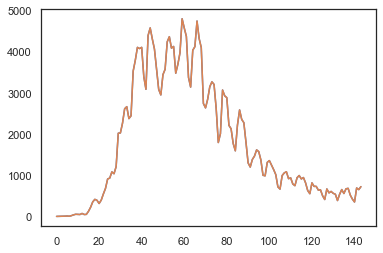

In [88]:
plt.plot(y_train)
plt.plot(mean)

In [114]:
mean, var = m.predict_f(X_test)
#mean, var = m.predict_y(X_test)

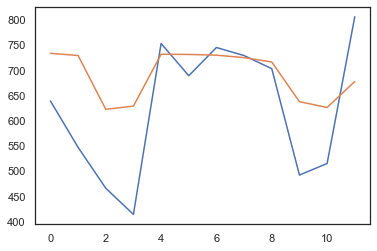

In [115]:
plt.plot(y_test)
plt.plot(mean)

In [53]:
np.sqrt(np.mean((y_test - mean.numpy())**2))

117.38400911605837

**Notes** a) When we use only the time as independent variable in the Gaussian Process model the RMSE is 360 b) when we use all the variables te RMSE is 544 (test_n=44) c) the time-only dependent model offers more smoothed results and it does not overfit the data as much d) by decreasing the test size to test_n=27 then the RMSE=184 e) for the equivalent multivariable GP model (test_n=29) the RMSE=195

We can actually predict the next 10 days. 

Play with te set, how changes in mobility affect the results?

Perform another test, check the most recent results.

array([2.58660126, 1.29549234, 1.78490137])

In [107]:
X_latest = np.append(X_test[:,0:3].mean(axis=0) + 5, [160., 1.])
X_latest = X_latest.reshape((1, -1))
mean, var = m.predict_f(X_latest)
print("The mean value is {0} and the variance {1}".format(mean, var))

The mean value is [[486.31193286]] and the variance [[33593005.71937115]]


# Variational Bayesian non-parametric inference for infectious disease models

In this approach we follow Hensman and Kypraios paper. 

1. $\beta(t)$S(t)I(t) with $\beta(t)$ = exp($f$(t)); the GP model allows the person to person infenction to be non-constant and time-varying
2. $\lambda(t)$ = exp($f$(t)); the GP model depends only on time
3. 